In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# create dataframe with two columns: 
## path_sample_img: image path in sample
## label: Healthy ou Sick
def make_dataFrame(list_path_sample_img: list) -> pd.DataFrame:

    df_sample_img = pd.DataFrame(columns = ["path_sample_img", "label"])
    for path_img in tqdm(list_path_sample_img):

        _, file_name, _ = utils.split_file_info(path_img)
        label = file_name[0]
        df_temporary = pd.DataFrame({"path_sample_img": path_img,
                                     "label": label}, index = [0])
        df_sample_img = pd.concat([df_sample_img, df_temporary])

    # randomise and reset index
    df_sample_img = df_sample_img.sample(frac=1).reset_index(drop = True)
    return df_sample_img

In [9]:
# set options 
pd.set_option('display.max_colwidth', None)
# to rest options
# pd.reset_option('^display.', silent=True)

In [10]:
df_sample_img = make_dataFrame(list_path_sample_img)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1808.73it/s]


In [11]:
df_sample_img.sample(5)

,path_sample_img,label
15601,../data/sample/2021-11-18_20-39-00\S_C39P4thinF_original_IMG_20150622_111942_cell_19.pklz,S
16337,../data/sample/2021-11-18_20-39-00\S_C81P42ThinF_IMG_20150817_120712_cell_162.pklz,S
5739,../data/sample/2021-11-18_20-39-00\H_C52P13thinF_IMG_20150725_125847_cell_1.pklz,H
4403,../data/sample/2021-11-18_20-39-00\H_C160P121ThinF_IMG_20151116_093704_cell_72.pklz,H
1404,../data/sample/2021-11-18_20-39-00\S_C59P20thinF_IMG_20150803_112733_cell_182.pklz,S


In [12]:
# split train, validation, test set
df_path_sample_img_train, df_path_sample_img_test  = train_test_split(df_sample_img, test_size=0.2, random_state=1, \
                                                                          stratify=df_sample_img.label)

df_path_sample_img_train, df_path_sample_img_valid = train_test_split(df_path_sample_img_train, test_size=0.2, \
                                                                      random_state=1, stratify=df_path_sample_img_train.label)

In [13]:
# # split train, validation, test set
# list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
# list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [14]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [15]:
X_train, y_train  = make_Xy(df_path_sample_img_train.path_sample_img)

12800it [00:10, 1172.60it/s]


In [16]:
X_valid, y_valid  = make_Xy(df_path_sample_img_valid.path_sample_img)

3200it [00:02, 1193.59it/s]


In [17]:
X_test, y_test  = make_Xy(df_path_sample_img_test.path_sample_img)

4000it [00:03, 1152.41it/s]


In [18]:
# verification
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_test,  return_counts=True))

(array(['H', 'S'], dtype='<U1'), array([6400, 6400], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([1600, 1600], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([2000, 2000], dtype=int64))


In [19]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(12800, 64, 64, 3)
(3200, 64, 64, 3)
(4000, 64, 64, 3)


# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [20]:
BATCH_SIZE = 500
#percentage = 0.10
#BATCH_SIZE = int(len(X_train) * percentage)

NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [21]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()

In [23]:
y_train_enc = le.fit_transform(y_train)

In [24]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [25]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [26]:
#!pip uninstall tensorflow

Créer un fichier .reg avec les instructions suivantes :

===

Windows Registry Editor Version 5.00

[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem]
"LongPathsEnabled"=dword:00000001

---

Exécuter le .reg

In [27]:
#!pip install tensorflow

In [28]:
import tensorflow as tf

In [29]:
from keras.models import Sequential

In [30]:
#assert False

In [31]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

In [75]:
def make_model(seq_num: int, drop_out_rate: float) -> Sequential:
    model_cnn_6 = Sequential(name="cnn_" + str(seq_num) + "_drop_out_" + str(drop_out_rate))
    model_cnn_6.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D",
                                         filters=32,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                         filters=64,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_2"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_3",
                                         filters=128,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_3", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_3"))

    model_cnn_6.add(tf.keras.layers.Flatten(name="flatten"))
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden", units = 1024, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

    # compiler modele
    model_cnn_6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),\
                        loss ="binary_crossentropy", metrics=["accuracy"])

    return model_cnn_6

In [76]:
model_cnn_6 = make_model(6, 0.2)

In [78]:
model_cnn_6.summary()

Model: "cnn_6_drop_out_0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [69]:
aug = ImageDataGenerator(rotation_range=359, \
                         zoom_range=0.15, \
                         width_shift_range=0.2, height_shift_range=0.2, \
                         shear_range=0.15, \
                         horizontal_flip=True, \
                         vertical_flip=True, \
                         fill_mode="nearest")

In [70]:
len(X_train) // BATCH_SIZE

25

In [71]:
tf.__version__

'2.7.0'

In [46]:
history_6 = model_cnn_6.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 51s 2s/step - loss: 3.8504 - accuracy: 0.5082 - val_loss: 0.6712 - val_accuracy: 0.5503
Epoch 2/25
25/25 [==============================] - 48s 2s/step - loss: 0.7033 - accuracy: 0.5396 - val_loss: 0.9816 - val_accuracy: 0.5053
Epoch 3/25
25/25 [==============================] - 48s 2s/step - loss: 0.6566 - accuracy: 0.6140 - val_loss: 1.7821 - val_accuracy: 0.5031
Epoch 4/25
25/25 [==============================] - 48s 2s/step - loss: 0.6423 - accuracy: 0.6355 - val_loss: 2.1795 - val_accuracy: 0.5041
Epoch 5/25
25/25 [==============================] - 48s 2s/step - loss: 0.6345 - accuracy: 0.6479 - val_loss: 2.2727 - val_accuracy: 0.5072
Epoch 6/25
25/25 [==============================] - 49s 2s/step - loss: 0.6312 - accuracy: 0.6508 - val_loss: 2.1158 - val_accuracy: 0.5081
Epoch 7/25
25/25 [==============================] - 49s 2s/step - loss: 0.6365 - accuracy: 0.6459 - val_loss: 1.3829 - val_accuracy: 0.5178
Epoch 8/25
25/25 [==

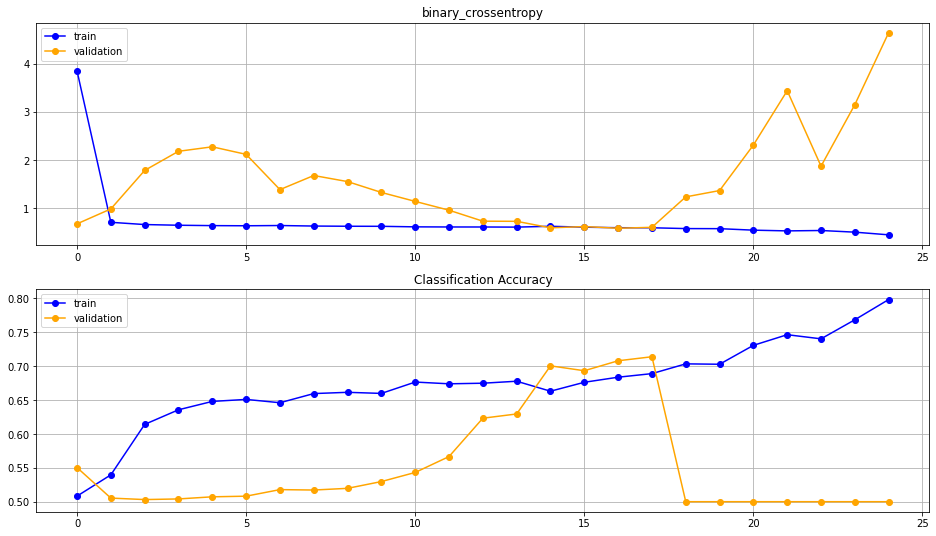

In [47]:
plot_history(history_6)

In [48]:
y_pred_proba = model_cnn_6.predict(X_test)

In [49]:
def get_classes(y_pred_proba: np.array, le:LabelEncoder) -> np.array:
    y_pred_class_num = np.rint(y_pred_proba).astype(int)
    y_pred_class_text = le.inverse_transform(y_pred_class_num.ravel())
    return y_pred_class_text

In [50]:
y_pred = get_classes(y_pred_proba, le)

Légende :
* H : Healthy
* S : Sick

In [80]:
type(y_pred)

numpy.ndarray

In [81]:
def get_metrics(y_test: np.array, y_pred: np.array)->(pd.DataFrame, pd.DataFrame):
    # create dataframe metrics
    df_metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), columns = ["H", "S"], 
             index=["Precion", "Recall", "F1", "Support"])
    # add average column    
    df_metrics["average_macro"] = precision_recall_fscore_support(y_test, y_pred, average = "macro")
    df_metrics = df_metrics.replace(np.nan, -999)
    sr_metrics = df_metrics.stack(dropna=False)

    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ["cm_H", "cm_S"], index = ["cm_H", "cm_S"])
    sr_confusion_matrix = df_confusion_matrix.stack()
    sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])
    
    return df_metrics, df_confusion_matrix

In [82]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

c:\users\rené\documents\rene\ia\ia297\jupyter\420-a62-bb_projetsynthese\projet_keras\keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rené\documents\rene\ia\ia297\jupyter\420-a62-bb_projetsynthese\projet_keras\keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
df_metrics

,H,S,average_macro
Precion,0.0,0.500000,0.250000
Recall,0.0,1.000000,0.500000
F1,0.0,0.666667,0.333333
Support,2000.0,2000.000000,-999.000000


In [84]:
df_confusion_matrix

,cm_H,cm_S
cm_H,0,2000
cm_S,0,2000


## Dropt out 0.1

In [88]:
model_cnn_7 = make_model(7, 0.1)

In [89]:
model_cnn_7.summary()

Model: "cnn_7_drop_out_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)

In [90]:
history_7 = model_cnn_7.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 48s 2s/step - loss: 3.0553 - accuracy: 0.5029 - val_loss: 0.6954 - val_accuracy: 0.5203
Epoch 2/25
25/25 [==============================] - 49s 2s/step - loss: 0.6799 - accuracy: 0.5760 - val_loss: 0.6473 - val_accuracy: 0.6375
Epoch 3/25
25/25 [==============================] - 51s 2s/step - loss: 0.6552 - accuracy: 0.6181 - val_loss: 0.6615 - val_accuracy: 0.6012
Epoch 4/25
25/25 [==============================] - 51s 2s/step - loss: 0.6352 - accuracy: 0.6520 - val_loss: 0.7774 - val_accuracy: 0.5544
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 0.6325 - accuracy: 0.6518 - val_loss: 0.9123 - val_accuracy: 0.5506
Epoch 6/25
25/25 [==============================] - 50s 2s/step - loss: 0.6469 - accuracy: 0.6363 - val_loss: 0.6201 - val_accuracy: 0.6669
Epoch 7/25
25/25 [==============================] - 50s 2s/step - loss: 0.6337 - accuracy: 0.6499 - val_loss: 0.6466 - val_accuracy: 0.6388
Epoch 8/25
25/25 [==

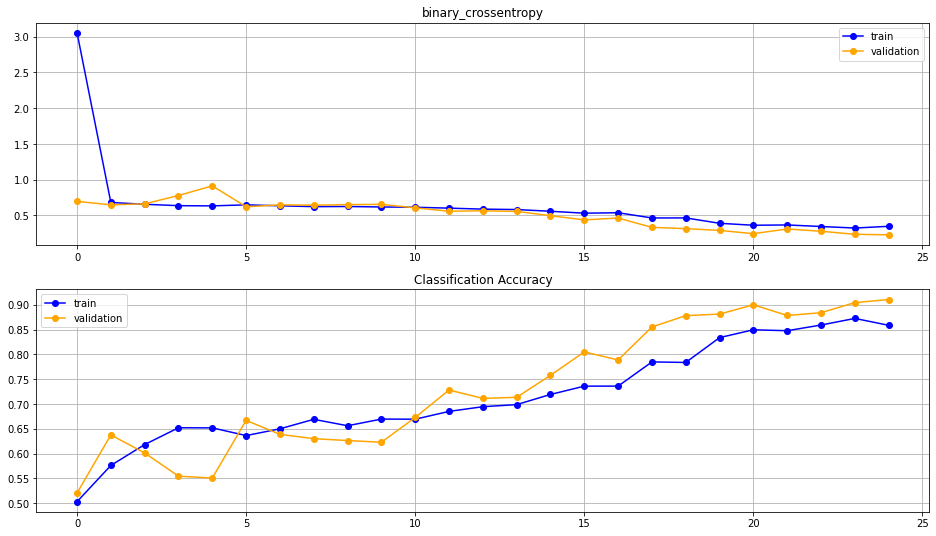

In [96]:
plot_history(history_7)

In [91]:
y_pred_proba = model_cnn_7.predict(X_test)

In [92]:
y_pred = get_classes(y_pred_proba, le)

In [93]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

In [94]:
df_metrics

,H,S,average_macro
Precion,0.904,0.904,0.904
Recall,0.904,0.904,0.904
F1,0.904,0.904,0.904
Support,2000.000,2000.000,-999.000


In [95]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1808,192
cm_S,192,1808


## Drop out 0.05

In [97]:
model_cnn_8 = make_model(8, 0.05)

In [99]:
model_cnn_8.summary()

Model: "cnn_8_drop_out_0.05"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128

In [100]:
history_8 = model_cnn_8.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 49s 2s/step - loss: 2.7777 - accuracy: 0.5026 - val_loss: 0.6961 - val_accuracy: 0.5075
Epoch 2/25
25/25 [==============================] - 47s 2s/step - loss: 0.6751 - accuracy: 0.5782 - val_loss: 0.6549 - val_accuracy: 0.6087
Epoch 3/25
25/25 [==============================] - 47s 2s/step - loss: 0.6490 - accuracy: 0.6315 - val_loss: 0.6221 - val_accuracy: 0.6609
Epoch 4/25
25/25 [==============================] - 47s 2s/step - loss: 0.6654 - accuracy: 0.5929 - val_loss: 0.6876 - val_accuracy: 0.5669
Epoch 5/25
25/25 [==============================] - 48s 2s/step - loss: 0.6377 - accuracy: 0.6463 - val_loss: 0.6487 - val_accuracy: 0.6347
Epoch 6/25
25/25 [==============================] - 48s 2s/step - loss: 0.6271 - accuracy: 0.6633 - val_loss: 0.6623 - val_accuracy: 0.6344
Epoch 7/25
25/25 [==============================] - 48s 2s/step - loss: 0.6140 - accuracy: 0.6706 - val_loss: 0.6858 - val_accuracy: 0.6272
Epoch 8/25
25/25 [==

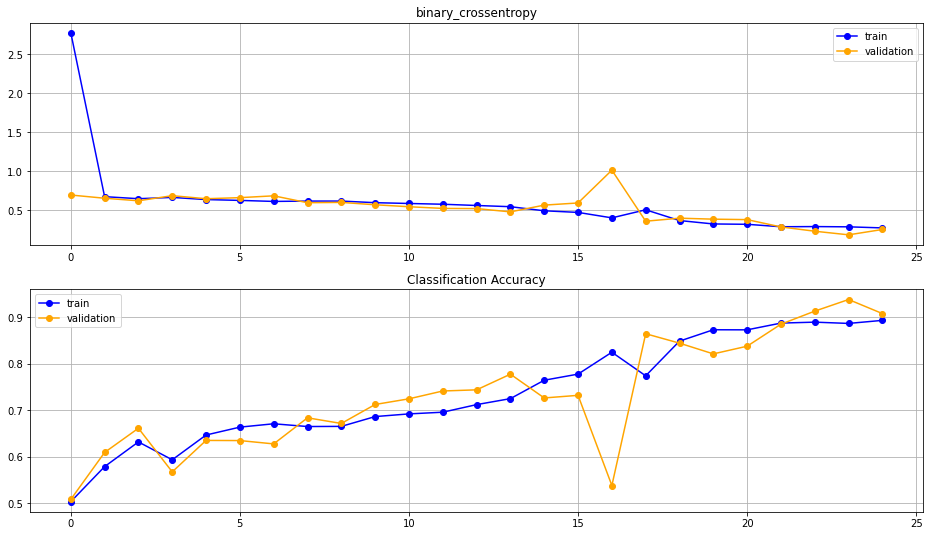

In [101]:
plot_history(history_8)

In [102]:
y_pred_proba = model_cnn_8.predict(X_test)

In [103]:
y_pred = get_classes(y_pred_proba, le)

In [104]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

In [105]:
df_metrics

,H,S,average_macro
Precion,0.940212,0.894313,0.917262
Recall,0.888500,0.943500,0.916000
F1,0.913625,0.918248,0.915936
Support,2000.000000,2000.000000,-999.000000


In [106]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1777,223
cm_S,113,1887


# TODO

* Mettre des dropOut
* faire équivalent de predict_classes() qui n'existe plus dans tf nouvelle version.:
*   On pourra utiliser la proba retournée par model.predict, if >0.50 classe 1
* evaluer avec X_test et matrice de confusion
* reprendre les lignes de suivi des metriques avec MLFlow comme on a fait pour RandomForest
* sauvegarder model_cnn + X_train etc.. et push dans gdrive

In [ ]:
# # matrice de confusion
# from sklearn import metrics
# metrics.confusion_matrix(y_test_enc, y_pred, normalize="true")

In [ ]:
#Augmenter Batch Size = int(len(X_Tain) * %) + 1
#Reduire le learning rate

In [ ]:
#model_cnn_4.save(PATH_MODEL + "/model_cnn_4.h5")

Keras avec GPU AMD
https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce